# TP2 IA -Tech
## Louis Henri Franc (1861683)

##  Introduction
Dans ce TP, nous allons implémenter la régression logistique, entrainée par une descente de gradent. L'objectif du TP, est de comparer la descente de gradient sur un batch entier versus l'approche mini batch. 
#### Choix du language et de la librairie
Pour implémenter la méthode j'ai décidé d'utiliser python et la librairie de manipulation de tenseurs numpy.  
#### 1.Implémentation de la méthode
Dans un premier temps, j'ai implémenter la méthode demandée (batch ou mini batch). L'optimisation s'arrête en suivant le principe d'early stopping, qui est une forme de régularisation L2 dans le contexte d'une regression linéaire avec une fonction de cout quadratique. Dans le code cela est implémenté en comparant la moyenne de l'accuracy de validation sur les 5 dernières époques comparées aux 15 épochs précédentes (le chiffre 5 est un hyperparamètre):
```python
 if np.mean(val_accuracy[-args.patience:]) <= np.mean(val_accuracy[-args.patience * 3:-args.patience]):
    stop
```
#### 2. Présentation des différents graphes
Dans cette partie, j'ai affiché les différents graphes demandées
#### En plus: Optimisation bayésienne avec le logiciel __Spearmint__
Puis j'ai testé plusieurs méthodes additionnels afin d'essayer d'améliorer la généralisation du modèle (l'accuracy de l'ensemble de test): par exemple avec du bruit gaussien dans les gradients, un terme de patience (early stopping), et aussi différentes méthodes de descente de gradient avec taux d'apprentissage adaptatif (momentum, nesterov, rmsprop). Toutes ces méthodes constituent des hyperparamètres pour le modèle. J'ai donc chercher les meilleurs HP en suivant une approche bayésienne avec le logiciel __Spearmint__.



## 1.Implémentation de la méthode

In [1]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import csv
import sys
import os

### Quelques fonctions utilitaires

In [2]:
def plot(data, legend):
    plt.plot(data)
    plt.legend(legend)
    plt.show(data)


def reading_file(filename):
    """
    Read files
    :param filename:
    :return:
    """
    try:
        path = os.path.join(os.path.split(os.path.realpath(__file__))[0], filename)
    except NameError: 
        path= filename
    with open(path, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        X = []
        for row in reader:
            X.append([int(element) for element in row])
        return np.array(X)


def one_hot(Y):
    """
    Transform the vector into a one hot vector
    :param Y:
    :return:
    """
    return (np.arange(Y.max()) == Y[:, None] - 1).astype(int)


def split(X, args):
    """
    Split between training - validation - testing phase
    :param X:
    :param args:
    :return:
    """
    return np.split(X, [int((1 - args.test_p - args.val_p) * X.shape[0]), int((1 - args.test_p) * X.shape[0])])

def preprocess(args):
    """
    Preprocess the input and split between validation-training-test set
    :param args:
    :return:
    """
    X = reading_file(filename='documents.txt')
    Y = reading_file(filename='newsgroups.txt')

    # Add bias term
    X = np.vstack((X, np.ones((1, X.shape[1]))))
    # One hot the vector
    Y = one_hot(Y.reshape(Y.shape[-1]))

    # Shuffle elements
    index_permuted = np.random.permutation(X.shape[1])
    Y = Y[index_permuted]
    X = X[:, index_permuted]

    # Split between training, testing, validation test
    X_train, X_val, X_test = (np.transpose(x) for x in split(np.transpose(X), args))
    y_train, y_val, y_test = split(Y, args)
    return X_train, y_train, X_val, y_val, X_test, y_test


def yield_batch(X, Y, batch_size):
    """
    Yield a batch of feature vector and target vector of size: batch_size
    """
    indices = np.random.permutation(np.arange(X.shape[1]))
    for index in np.arange(0, X.shape[0], batch_size):
        yield X[:, indices[index: index + batch_size]], Y[indices[index: index + batch_size], :]

def plot(train_accuracy, val_accuracy, test_accuracy, log_likelihood):
    """
    Plot train accuracy/ val _accuracy/ test_accuracy and log likelihood
    """
    plt.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth=2, label="train_accuracy")
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, 'b', linewidth=2, label="validation_accuracy")
    plt.axhline(y=test_accuracy, xmin=0, xmax=len(train_accuracy), hold=None, linewidth=2, label="test_accuracy", color='g')
    plt.legend(loc='lower right')
    plt.suptitle('Accuracy wrt the number of epochs', fontsize=20)
    plt.xlabel("Number of epochs", fontsize=18)
    plt.ylabel("Accuracy", fontsize=18)
    plt.show()
    plt.plot(log_likelihood, label="log likelihood")
    plt.legend(loc="lower right")
    plt.suptitle("Log likelihood wrt the number of epochs")
    plt.xlabel("Number of epochs (1e8)", fontsize=18)
    plt.ylabel("Log likelihood", fontsize=18)
    plt.show()
    
# THIS CLASS IS ONLY USED FOR ADAGRAD METHOD WHERE PREVIOUS GRADIENT MUST BE SAVED, AND
# ACCUMULATED
class Array():
    def __init__(self):
        self.array = None

    def append(self, new_value):
        if self.array is None:
            self.array = np.expand_dims(new_value, axis=2)
        else:
            self.array = np.dstack((self.array, new_value))

    def _stack(self):
        self.array = np.sum(self.array, axis=2)

    def __getitem__(self, key):
        return self.array[key]

    def __len__(self):
        if self.array is None:
            return 0
        return self.array.shape[-1]

### Implémentation de la régression logistique

In [3]:
class LR():
    def __init__(self, args):
        """
        Build a simple logistic regression
        :param args:
        """
        self.nb_targets = args.nb_targets # nb targets classes
        self.nb_features = args.nb_features # nb feeatures in the feature vector
        self.learning_rate = args.learning_rate # learning rate

        self.W = np.random.standard_normal((self.nb_targets, self.nb_features))
        self.b = np.zeros(self.nb_features)

        self.gradients, self.updates = Array(), Array() # special array to allow accumulate gradients
        self.optimizer = args.optimizer # optimizer
        self.momentum = args.momentum # momentum decay
        self.nb_epochs = 0 # nb epochs

    def prediction(self, x):
        """
        Predict y value given x and return \sum(exp(W dot x)) to avoid re-computation
        :param x: np.array
            Batch value of value to predict
        :return: np.array, np.array
            Prediction, z value
        """
        # size: (nb_targets, batch_size)
        numerator = np.exp(np.matmul(self.W, x))

        # size: (batch_size)
        z = np.sum(numerator, axis=0)

        # size: (nb_targets, batch_size)
        denominator = np.tile(
            np.expand_dims(
                np.transpose(
                    z), axis=0),
            reps=[numerator.shape[0], 1])

        # size: (nb_targets, batch_size)
        return np.divide(numerator, denominator), z

    def forward_pass(self, x, y):
        """
        Forward pass:
            * Compute the log likelihood
            * Compute the gradients, and call the backward_pass to update the parameters
        :param x: np.array
            Feature vector
        :param y: np.array
            Feature vector
        :return: float
            Log likelihood
        """
        # 1. Compute Y|X
        y_hat, z = self.prediction(x)
        if self.optimizer != "nesterov":
            self.gradients.append(np.matmul(np.transpose(y), np.transpose(x)) - np.matmul(y_hat, np.transpose(x)))
        else:
            # gradient are computed with respect to the current position of the parameter
            # in the space + the momentum vector translation
            oldW = np.copy(self.W)
            if len(self.updates) > 1:
                self.W += self.momentum * self.updates[:, :, -1]
            self.gradients.append(np.matmul(np.transpose(y), np.transpose(x)) - np.matmul(y_hat,
                                                                                          np.transpose(
                                                                                              x)))
            self.W = oldW
        log_likelihood = self._compute_log_likelihood(x, y, z)
        self.nb_epochs += 1
        self._bacward_pass()

        return log_likelihood

    def _compute_log_likelihood(self, x, y, z):
        """
        Compute the log likelihood for the data
        :param x: np.array
            Feature vector
        :param y: np.array
            Target vector
        :param z: np.array
            Z value from the assignement (cached value)
        :return: float
            The log likelihood
        """
        # 2. Compute log likelihood
        log_likelihood = np.sum(np.sum(np.transpose(np.matmul(y, self.W)) * x) - np.log(z))
        # print("Log likelihood {}".format(log_likelihood))
        return log_likelihood

    def _bacward_pass(self):
        """
        Update the parameter with the gradient
        Different optimization method are possible
        :return: None
        """
        # Simple gradient descent
        if self.optimizer == "sgd":
            self.updates.append(self.gradients[:, :, -1] * self.learning_rate)

        # Momemtum and Nesterov method are quite similar method,
        # except that for Nesterov method, the gradient were computed
        # with respect to the parameter + the momentum (gradient is
        # a correction of the momentum vector)
        elif self.optimizer in ["momentum", "nesterov"]:
            last_update = self.learning_rate * self.gradients[:, :, -1]
            if len(self.updates) > 1:
                last_update += self.momentum * self.updates[:, :, -1]
            self.updates.append(last_update)

        elif self.optimizer == "rmsprop":

            expectation = np.sqrt(
                0.9 * self.gradients.array[:, :, 0] ** 2 + 0.1 * self.gradients.array[:, :, -1] ** 2 + 1e-8)
            if len(self.gradients) > 5:
                self.updates.append(self.learning_rate * np.divide(self.gradients[:, :, -1], expectation))
            else:
                self.updates.append(self.learning_rate * self.gradients[:, :, -1])
            self.gradients._stack()
            # Add gaussian noise with a weigth decay to the gradient

        gaussian_noise = 0
        if gaussian_noise:
            gaussian_noise = np.random.normal(0, self.learning_rate / (1 + self.nb_epochs) ** 0.95)

            # Update the parameters
        self.W += self.updates[:, :, -1] + gaussian_noise

    def accuracy(self, x, y):
        """
        Compute the mean accuracy (correct prediction of a document in group name)
        :param x: np.array
            Feature vector
        :param y: np.array
            Target vector
        :return: 0 < float < 1
            Average of correct predicted values
        """
        y_hat, _ = self.prediction(x)
        return np.mean(np.argmax(y_hat, axis=0) == np.argmax(np.transpose(y), axis=0))


In [4]:
def train(args):
    # Create a logistic regression holder
    lr = LR(args)
    # Retrieve data splitted
    X_train, y_train, X_val, y_val, X_test, y_test = preprocess(args)

    # If batch_size is not set then use the all batch to compute the gradient
    if args.batch_size == -1:
        args.batch_size = X_train.shape[1]  # full_batch
    if args.debug: 
        print("Batch size {}".format(args.batch_size))
    val_accuracy, train_accuracy, log_likelihood = [], [], []
    while True:
        # Training phase
        for X_train_batch, y_train_batch in yield_batch(X_train, y_train, args.batch_size):
            log_likelihood.append(lr.forward_pass(X_train_batch, y_train_batch))
            train_accuracy.append(lr.accuracy(X_train_batch, y_train_batch))

        # Validation phase
        val_accuracy.append(lr.accuracy(X_val, y_val))
        if args.debug:
            print("Validation accuracy {}".format(val_accuracy[-1]))

        # Early stopping
        if lr.nb_epochs > (args.patience * 3) and np.mean(val_accuracy[-args.patience:]) <= np.mean(
                val_accuracy[-args.patience * 3:-args.patience]):
            break
    # Testing phase
    test_accuracy = lr.accuracy(X_test, y_test)
    if args.debug:
        print("Converged in {} epochs".format(lr.nb_epochs))
        print("Testing accuracy {} ".format(test_accuracy))
    if args.plot:
        plot(train_accuracy, val_accuracy, test_accuracy, log_likelihood)
    return - test_accuracy

Afin de trouver les meilleures hyperparameters (learning rate, momentum decay, patience, méthode d'optimisation, bruit gaussien dans le gradient), j'ai utilisé le logiciel __Spearmint__, pour cela il faut définir une fonction qui recoit les différents paramètres d'une session spearmint, et qui renvoit la valeur que l'on cherche à optimiser (ici on cherche à maximiser l'accuracy de l'ensemble de test, donc on minimise son inverse.

In [5]:
def main(job_id=None, params=None):
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=-1, help='Size of a batch')
    parser.add_argument('--patience', type=int, default=5, help='Patience windows')

    parser.add_argument('--nb_features', type=int, default=101, help='Number of features')
    parser.add_argument('--nb_targets', type=int, default=4, help='Number of targets')
    parser.add_argument('--nb_epochs', type=int, default=32, help='Number of epochs')

    parser.add_argument('--test_p', type=int, default=0.15, help='Percentage for testing phase')
    parser.add_argument('--val_p', type=int, default=0.15, help='Percentage for validation phase')

    parser.add_argument('--optimizer', type=str, default="sgd", help='Optimization method (sgd|rmsprop|nesterov|momentum)')
    parser.add_argument('--learning_rate', type=int, default=0.0009, help='Learning rate')
    parser.add_argument('--momentum', type=int, default=0.9, help='Momentum term')
    parser.add_argument('--debug', type=bool,default=False, help='Print information')
    parser.add_argument('--plot', type=bool,default=False, help='plot graphs')
    parser.add_argument('--gaussian_noise', type=bool,
                        default=True,
                        help='Gaussian noise')
    
    args, unknown = parser.parse_known_args()
    for key, value in params.items():
        if value[0] in ["True", "False"]:
            value[0] = True if value[0] == "True" else False
        vars(args)[key] = value[0]
    print(args)
    return train(args)

In [6]:
# Voici un test pour voir si cela fonctionne
main(params={"batch_size": [-1], "plot": ["False"]})

Namespace(batch_size=-1, debug=False, gaussian_noise=True, learning_rate=0.0009, momentum=0.9, nb_epochs=32, nb_features=101, nb_targets=4, optimizer='sgd', patience=5, plot=False, test_p=0.15, val_p=0.15)


-0.80098481739844074

## 2. Présentation des différents graphes

### Full batch
Dans cette version, la mise à jour des paramètres est effectué sur tout l'ensemble d'entrainement. A chaque itération les calculs sont plus gros, et donc la version full-batch prend plus de temps. 
Nous allons suivre l'évolution de l'accuracy pour les trois ensembles de tests, ainsi que le maximum de vraisemblance étant donné différentes valeurs de taux d'apprentissages

Namespace(batch_size=-1, debug=False, gaussian_noise=True, learning_rate=0.01, momentum=0.9, nb_epochs=32, nb_features=101, nb_targets=4, optimizer='sgd', patience=5, plot=True, test_p=0.15, val_p=0.15)


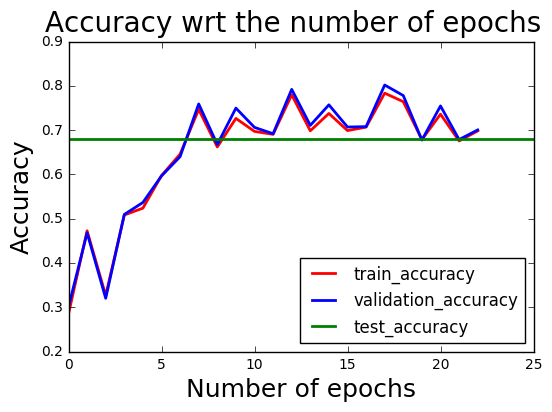

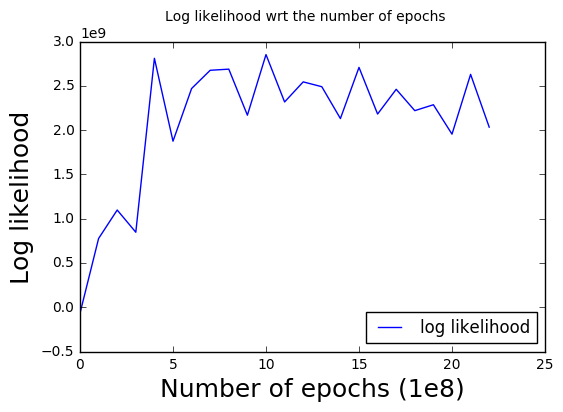

-0.6803446860894542

In [7]:
# large learning rate
main(params={"plot": ["True"], "learning_rate": [0.01]})

Lorsque la valeur du taux d'apprentissage est trop grand, le gradient oscille énormément. Comme la variation du gradient oscille beaucoup, il est difficile de converger vers un optimum, et la méthode se déplace de mimimum local en minimum local en dépassant à chaque fois le point de mimimum local, ainis l'accuracy varie énormément. La méthode utilisée de early-stopping, est sensible à cette variation d'accuracy, ainsi la méthode s'arrête assez rapidement, sans avoir converger correctement.

Namespace(batch_size=-1, debug=False, gaussian_noise=True, learning_rate=0.001, momentum=0.9, nb_epochs=32, nb_features=101, nb_targets=4, optimizer='sgd', patience=5, plot=True, test_p=0.15, val_p=0.15)


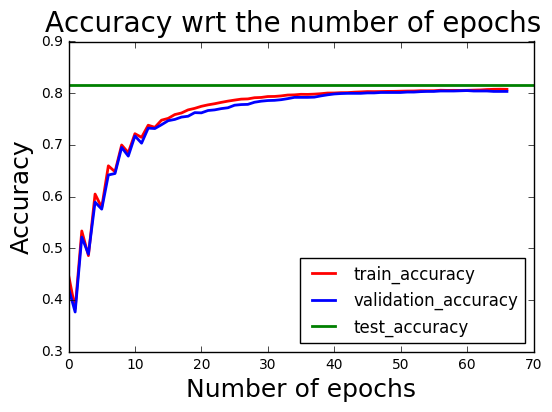

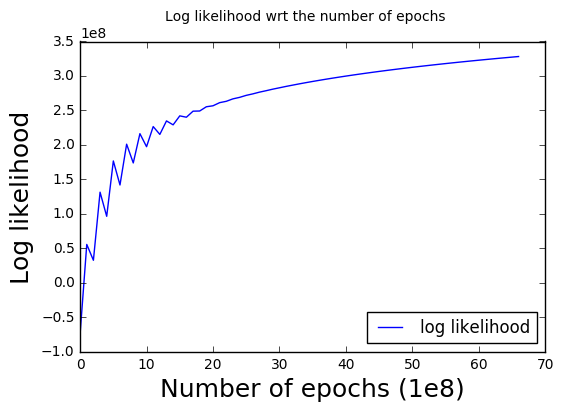

-0.81493639720968403

In [14]:
# medium learning rate
main(params={"plot": ["True"], "learning_rate": [0.001]})

Lorsque le taux d'apprentissage est suffisament petit, la convergence est plus lente, car le déplacement dans l'espace des paramètres est proportionnel à ce taux d'apprentissage. Ce choix de taux d'apprentissage permet à la méthode de converger vers un bon optimum qui donne une accuracy de test correct (0.81)

Ces deux examples montrent qu'il ne faut pas utiliser un taux d'apprentissage trop élevé, celui empeche toute convergence, car le gradient oscille dans toutes les directions. Pour tenir compte de la direction des précédents gradients, la méthode de Nesterov prend en compte le moment du précédent gradient.
La méthode de Nesterov consiste à:
1. Calculer le nouveau gradient $G$ en fonction d'une approximation de la futur position des paramètres: $\theta + \mu * v_{t-1}$ où $\mu v_{t-1}$ est le _momentum decay_.
2. Updater les paramètres suivant la formule $\theta - \mu v_{t-1} + \eta G$ où $\eta$ est le taux d'apprentissage

Namespace(batch_size=-1, debug=False, gaussian_noise=True, learning_rate=0.001, momentum=0.9, nb_epochs=32, nb_features=101, nb_targets=4, optimizer='nesterov', patience=5, plot=True, test_p=0.15, val_p=0.15)


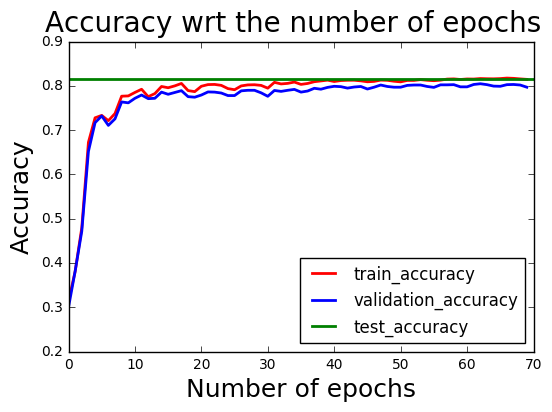

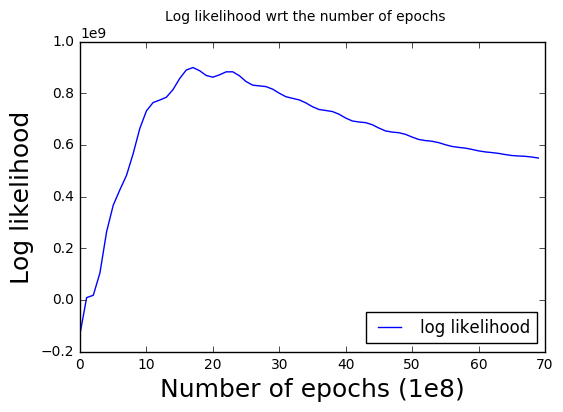

-0.81534673779236766

In [10]:
main(params={"plot": ["True"], "learning_rate": [0.001], "optimizer" : ["nesterov"]})

On n'observe pas une grande différence en utilisant la méthode de Nesterov. A noter que les experimentations sont toutes éxécutées avec différents ensembles de test, de validation, d'entrainement, mais aussi différentes initialisation de paramètre. __Il est raisonnable de penser que l'accuracy de test est sensible à ces variations entre chaque experimentations__

J'ai aussi implémenter certaines techniques simple de régularisation tels que le bruit gaussien sur le gradient, mais aussi le early stopping, voyons voir si ces paramètres font varier la convergence, et l'accuracy de tests (pas de plots juste l'accuracy de test final)

In [18]:
main(params={"learning_rate": [0.001], "optimizer" : ["nesterov"], "momentum": [0.90],
             "patience": [10], "gaussian_noise":["True"]})

Namespace(batch_size=-1, debug=False, gaussian_noise=True, learning_rate=0.001, momentum=0.9, nb_epochs=32, nb_features=101, nb_targets=4, optimizer='nesterov', patience=10, plot=False, test_p=0.15, val_p=0.15)


-0.82560525235945836

Les résultats sont évidemment sensibles aux ensembles d'initialisations, mais avec ces paramètres, l'accuracy de test est au delà de 0.82

## Mini batch
La méthode de mini batch consiste à mettre à jour le gradient plus souvent. Le gradient est mise à jour en fonction d'un ensemble d'exemples de taille __batch_size__. En général, dans des problèmes non convexe, la méthode mini batch est préférée, car plus rapide, moins couteuse, et elle permet d'explorer plus en largeur l'ensemble de valeurs des paramètres du modèle. 
Ici le problème est convexe, donc la méthode full batch fonctionnait bien, de plus la complexité du calcul est relativement faible.

Namespace(batch_size=100, debug=False, gaussian_noise=True, learning_rate=0.001, momentum=0.9, nb_epochs=32, nb_features=101, nb_targets=4, optimizer='nesterov', patience=10, plot=True, test_p=0.15, val_p=0.15)


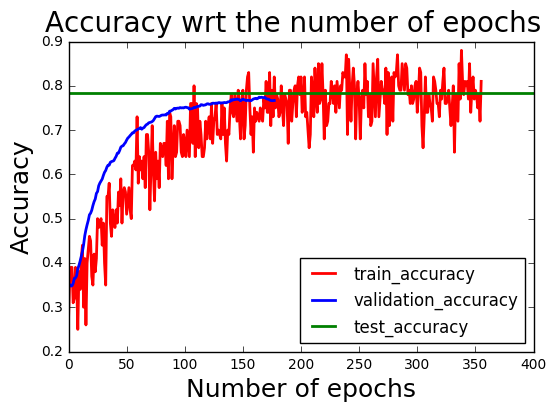

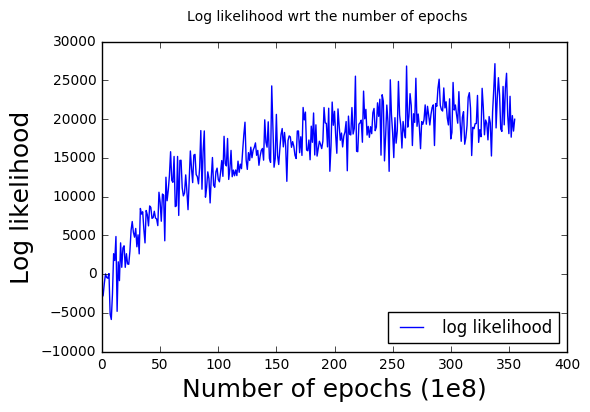

-0.78416085350841203

In [12]:
# petit ensemble de batch = 10 examples
main(params={"batch_size": [100], "plot": ["True"],
    "learning_rate": [0.001], "optimizer" : ["nesterov"], "momentum": [0.90], 
    "patience": [10], "gaussian_noise": [True]})

Lorsque la taille du mini batch est très petite, les oscillations de l'accuracy d'entrainement est très grande, ainsi que le log likelihood, car le gradient est mis à jour très souvent sur un ensemble de donnée petit, en effet les paramètres sont ajustées en fonction du peu d'example qui n'est pas forcément représentatif du jeu de données. 


Namespace(batch_size=1000, debug=False, gaussian_noise=True, learning_rate=0.001, momentum=0.9, nb_epochs=32, nb_features=101, nb_targets=4, optimizer='nesterov', patience=10, plot=True, test_p=0.15, val_p=0.15)


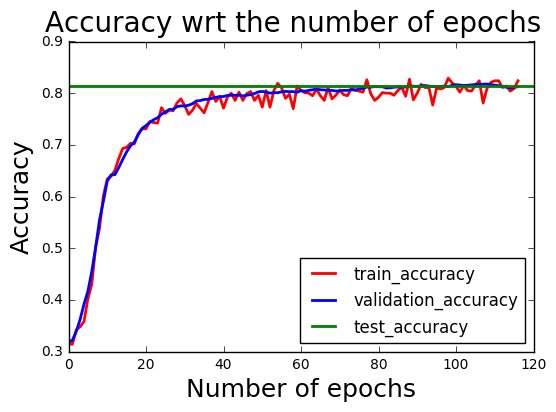

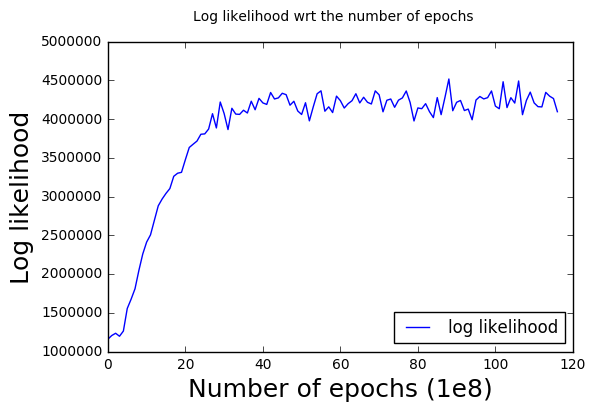

-0.81411571604431676

In [19]:
# taille de batch moyen = 1000
main(params={"batch_size": [1000], "plot": ["True"],
    "learning_rate": [0.001], "optimizer" : ["nesterov"], "momentum": [0.90], 
    "patience": [10], "gaussian_noise": [True]})

Lorsque l'on augmente la taille du batch, les oscillations sont moins présentes, car les examples du batch représentent mieux le jeu de données. Les oscillations à la fin sont sans doute liés au fait que la méthode d'entrainement oscille autour d'un mimimum local (pour cela il faudrait diminuer le taux d'apprentissage vers la fin de l'entrainement, afin de fixer les paramètres au plus bas de la vallée du minimum)

## Optimisation avec le logiciel Spearmint

Spearmint est un logiciel qui permet de trouver les meilleures hyperparameters d'un modèle d'apprentissage machine. Pour cela il approche le problème, en posant des aprioris bayésiens sur les différents paramètres, explorant l'espace des valeurs des hyper paramètres.  
Le logiciel est facile à prendre en main. Il suffit de définir un fichier de configuration où l'on précise le range de valeur de nos paramètres:
```
language: PYTHON
name:   "model"

variable {
    name: "batch_size"
    type: INT
    size: 1
    min: 1
    max: 11369
}

variable {
    name: "optimizer"
    type: ENUM
    size: 1
    options: "sgd"
    options: "momemtum"
    options: "nesterov"
    options: "rmsprop"
}

variable {
    name: "patience"
    type: INT
    size: 1
    min: 5
    max: 50
}

variable {
    name: "learning_rate"
    type: FLOAT
    size: 1
    min: 0.000001
    max: 0.01
}

variable {
    name: "gaussian_noise"
    type: ENUM
    size: 1
    options: "True"
    options: "False"
}

variable {
    name: "momentum"
    type: FLOAT
    size: 1
    min: 0.6
    max: 1.3
}
```

J'ai fait tourner Spearmint pendant 20 minutes, et voici le meilleur résultat obtenue:
```
Best result: -0.825605
Job-id: 19167
Parameters: 
name: "batch_size"
int_val: 621
name: "optimizer"
str_val: "rmsprop"
name: "patience"
int_val: 37
name: "learning_rate"
dbl_val: 0.00658511935425
name: "gaussian_noise"
str_val: "False"
name: "momentum"
dbl_val: 0.694311523438
```

Même en refesant l'expérience avec les mêmes hyper-paramètres, je n'ai pas pu ré-obtenir la même valeur de coût. __De surcroit, de nombreuses combinaisons de hyperparamètres sont corrects, et la variation d'accuracy test dépend en grande partie de l'arrangement des données lorsque l'on sépare notre jeu de donnée.__
